# Meta Analysis of Circuit Breaker Invitational

Cursory analysis of the data, seeing what we can learn about the meta.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests

In [3]:
r=requests.request(url="https://cobr.ai/tournaments/2756.json",method="GET")


In [4]:
raw_faction_data = requests.request(url="https://netrunnerdb.com/api/2.0/public/cards",method="GET").json()['data']
cards_df = pd.DataFrame(raw_faction_data)
id_df = cards_df[cards_df["type_code"] == "identity"].groupby(['stripped_title','faction_code']).size().reset_index()[['stripped_title','faction_code']]

faction_hues = {
    'shaper':'limegreen',
    'criminal':'royalblue',
    'anarch':'orangered',
    'adam':'gold',
    'jinteki':'crimson',
    'nbn':'darkorange',
    'haas-bioroid':'blueviolet',
    'weyland-consortium':'darkgreen'
}

In [5]:
raw_data = r.json()
players = pd.DataFrame(raw_data['players'])
elim_rankings = pd.DataFrame(raw_data["eliminationPlayers"])

In [6]:
aug_players = pd.merge(players, id_df, how='left',left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"corpFaction"})
aug_players = pd.merge(aug_players, id_df, how='left',left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"runnerFaction"})

In [7]:
import warnings
warnings.filterwarnings('ignore')
matches = pd.DataFrame(columns=['table','round','id','runnerScore','corpScore','combinedScore','intentionalDraw','twoForOne','eliminationGame'])
for rnd, tables in enumerate(raw_data['rounds']):
    for table_number, table in enumerate(tables):
        for player in ['player1','player2']:
            df = pd.DataFrame([table[player]])
            df['table'] = table_number
            df['round'] = rnd
            df['twoForOne'] = table['twoForOne']
            df['intentionalDraw'] = table['intentionalDraw']
            df['eliminationGame'] = table['eliminationGame']
            matches = pd.concat([matches, df],ignore_index=True)

matches.head()

,table,round,id,runnerScore,corpScore,combinedScore,intentionalDraw,twoForOne,eliminationGame,role,winner
0,0,0,30825,3,3,6,False,False,False,NaN,NaN
1,0,0,30816,0,0,0,False,False,False,NaN,NaN
2,1,0,30871,0,0,0,False,False,False,NaN,NaN
3,1,0,30875,3,3,6,False,False,False,NaN,NaN
4,2,0,30855,3,3,6,False,False,False,NaN,NaN


In [8]:
swiss_played_games = matches[(matches['intentionalDraw'] == False) & (matches['twoForOne'] == False) & (matches['eliminationGame'] == False)]
result=swiss_played_games[['runnerScore','corpScore']].agg('sum')
print(f"Runner Win Rate {round(result['runnerScore']/3/(result['corpScore']/3+result['runnerScore']/3)*100,1)}")

Runner Win Rate 39.8


In [9]:
# Uncomment this to get a table of the results from the top cut
# matches[(matches['eliminationGame'] == True) & matches['winner'] == True]

In [10]:
runner_wins = matches[(matches['eliminationGame'] == True) & (matches['winner'] == True) & (matches['role'] == "runner")].shape[0]

cut_games = matches[(matches['eliminationGame'] == True) & (matches['winner'] == True)].shape[0]

print(f"Runner Winrate (cut) {round(runner_wins/cut_games*100,1)}")

Runner Winrate (cut) 66.7


This table displays what the corp winrate was for each round. Typically the final round will have many fewer games because the data is excluding 241s and IDs (which occurr most frequently in the final round). And I'm not sure exactly why the combined score doesn't add up.

In [11]:
per_round_score = swiss_played_games.groupby(["round"]).agg(sum)
per_round_score["corp_wins"] = per_round_score["corpScore"] / (per_round_score['runnerScore'] + per_round_score['corpScore'])
per_round_score

,table,id,runnerScore,corpScore,combinedScore,intentionalDraw,twoForOne,eliminationGame,role,winner,corp_wins
round,,,,,,,,,,,
0,1332,2251860,87,129,222,0,0,0,0,0,0.597222
1,1260,2190157,81,123,215,0,0,0,0,0,0.602941
2,1190,2128445,78,120,210,0,0,0,0,0,0.606061
3,930,1912539,72,108,185,0,0,0,0,0,0.600000
4,634,1357361,60,66,132,0,0,0,0,0,0.523810
5,440,863809,18,54,84,0,0,0,0,0,0.750000


In [12]:
player_match_data = pd.merge(swiss_played_games,aug_players, on='id')
id_side_wins = player_match_data.groupby('id')[['runnerScore','corpScore']].aggregate("sum")
num_games_played_by_id = player_match_data.groupby(["id","runnerIdentity","corpIdentity"]).size().reset_index().rename(columns={0:"roundsplayed"})
rounds_played_by_id = pd.merge(id_side_wins,num_games_played_by_id,on='id')
rounds_played_by_id = pd.merge(rounds_played_by_id,id_df, left_on="runnerIdentity",right_on="stripped_title").rename(columns={"faction_code":"runnerFaction"}).drop(columns=["stripped_title"])
rounds_played_by_id = pd.merge(rounds_played_by_id,id_df, left_on="corpIdentity",right_on="stripped_title").rename(columns={"faction_code":"corpFaction"}).drop(columns=["stripped_title"])
runner_corp_dist = rounds_played_by_id.groupby(['runnerScore','corpScore']).size().reset_index().rename(columns={0:"num_players"})

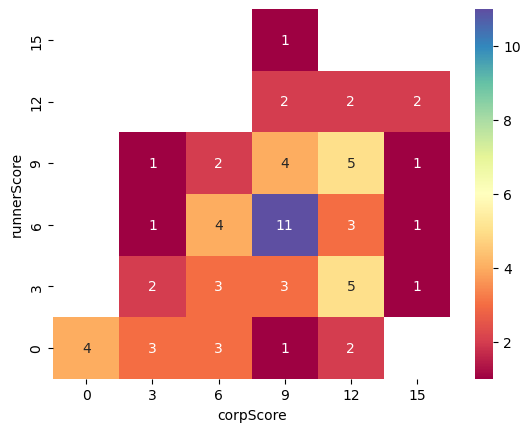

In [13]:
g = sns.heatmap(runner_corp_dist.pivot(columns="corpScore",index="runnerScore",values="num_players"),annot=True,cmap="Spectral")
g.invert_yaxis()
g.get_figure().savefig("heatmap.png")

In [14]:
rounds_played_by_id['corpWR'] = rounds_played_by_id['corpScore']/3 / rounds_played_by_id['roundsplayed']
rounds_played_by_id['runnerWR'] = rounds_played_by_id['runnerScore']/3 / rounds_played_by_id['roundsplayed']
# rounds_played_by_id.groupby(['corpWR','runnerWR']).size().reset_index().rename(columns={0:"num_players"})

<AxesSubplot: xlabel='corpWR', ylabel='runnerWR'>

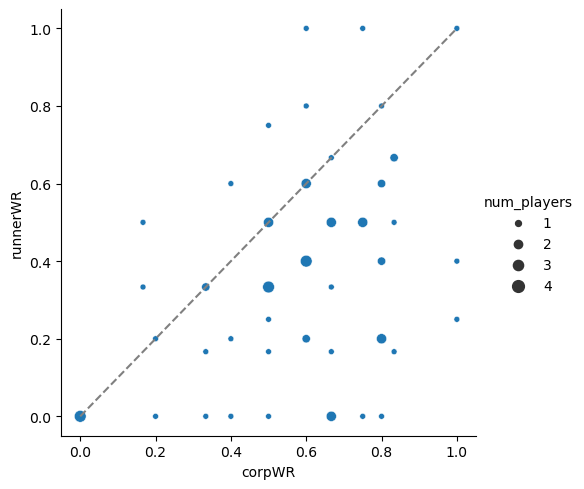

In [15]:
wr_table = rounds_played_by_id.groupby(['corpWR','runnerWR']).size().reset_index().rename(columns={0:"num_players"})
temp_df = pd.DataFrame({'x':[0,1],'y':[0,1]})


sns.relplot(wr_table, x="corpWR",y="runnerWR",size="num_players")
sns.lineplot(temp_df, x="x",y="y",color="gray",linestyle='--',legend=False)


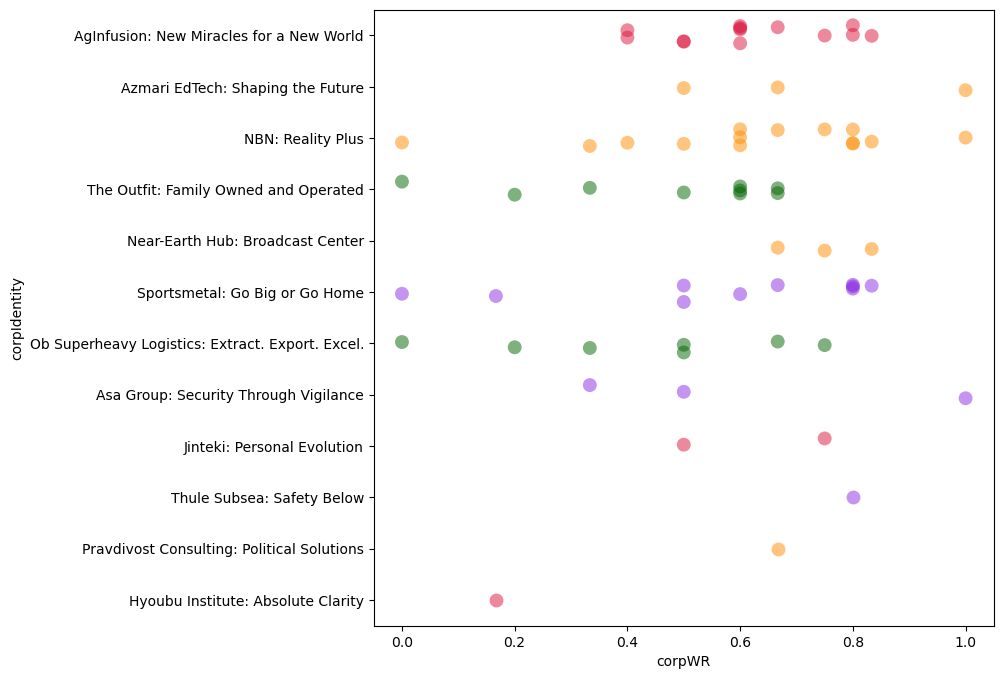

In [16]:
plt.figure(figsize=(8,8))
g=sns.stripplot(rounds_played_by_id,y="corpIdentity",x="corpWR",hue="corpFaction",palette=faction_hues,alpha=.5,size=10,jitter=.2,legend=False)
g.get_figure().savefig("corpWinrate.png",bbox_inches="tight")

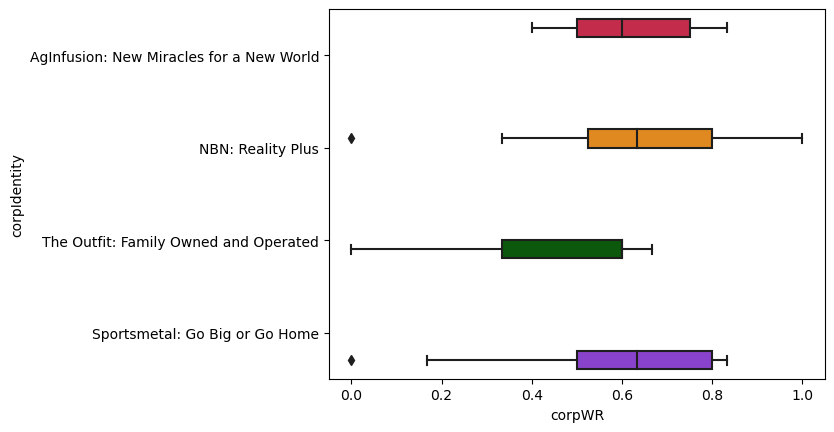

In [17]:
corp_playrate = rounds_played_by_id.groupby("corpIdentity").size().reset_index().rename(columns={0:"num_players"})
high_playrate_corps = list(corp_playrate[corp_playrate['num_players'] > 7]['corpIdentity'])
high_playrate_corps
sns.boxplot(rounds_played_by_id.query('corpIdentity in @high_playrate_corps'),x="corpWR",y="corpIdentity",hue='corpFaction',palette=faction_hues)
plt.legend().remove()

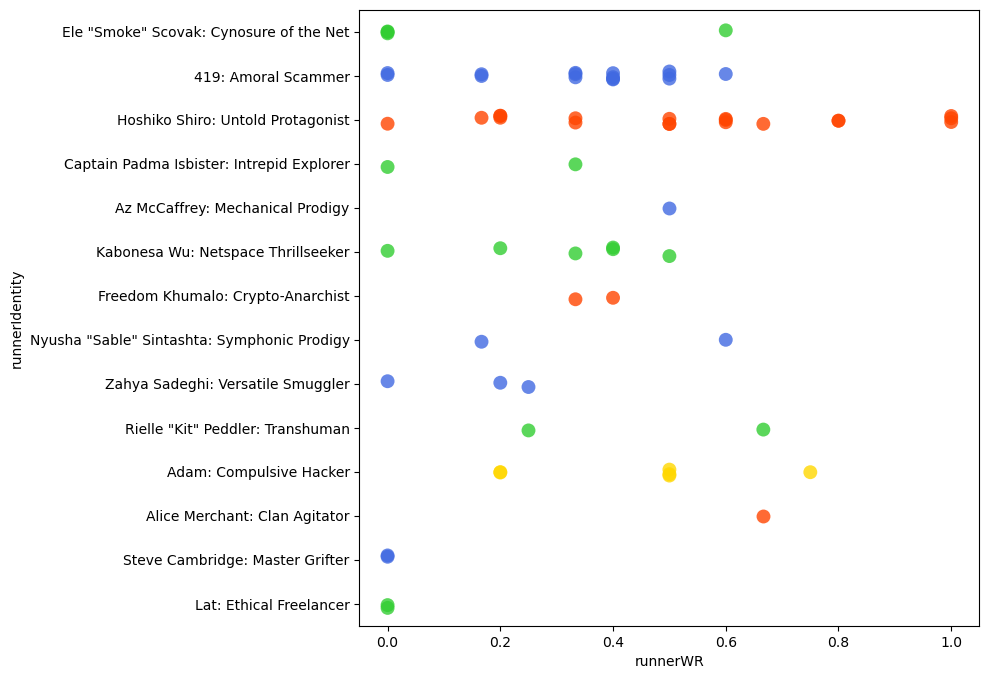

In [18]:
plt.figure(figsize=(8,8))
g=sns.stripplot(rounds_played_by_id,y="runnerIdentity",x="runnerWR",hue='runnerFaction',palette=faction_hues,alpha=.8,size=10)
g.get_figure().savefig("runnerWinrate.png",bbox_inches="tight")
g.legend().remove()

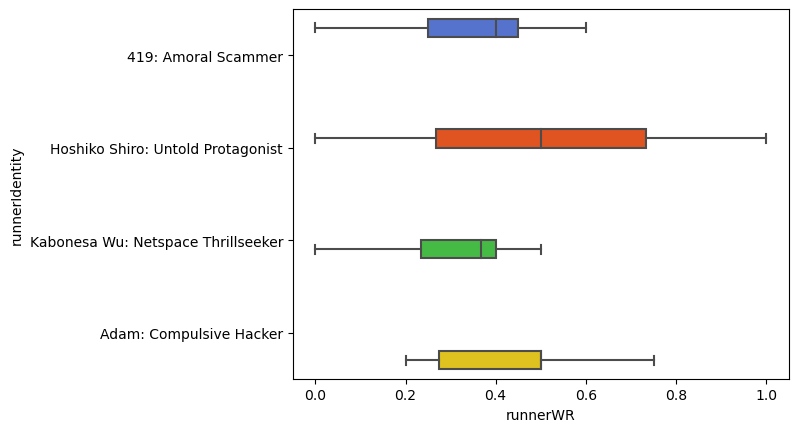

In [19]:
runner_playrate = rounds_played_by_id.groupby("runnerIdentity").size().reset_index().rename(columns={0:"num_players"})
high_playrate_runners = list(runner_playrate[runner_playrate['num_players'] > 5]['runnerIdentity'])
sns.boxplot(rounds_played_by_id.query('runnerIdentity in @high_playrate_runners'),x="runnerWR",y="runnerIdentity",hue="runnerFaction",palette=faction_hues)
plt.legend().remove()

In [110]:
KFACTOR = 16
players['elo'] = 1000

def elo_calculator(match: dict[str,dict[str,int]], players_df):
    player1 = match['player1']['id']
    player2 = match['player2']['id']
    p1_elo = float(players_df.loc[players_df['id']==player1,'elo'])
    p2_elo = float(players_df.loc[players_df['id']==player2,'elo'])
    expected_score_p1 = estimate_score(p1_elo,p2_elo)
    expected_score_p2 = 6 - expected_score_p1
    p1_score = match['player1']['combinedScore']
    p2_score = match['player2']['combinedScore']
    players_df.loc[players_df['id']==player1,'elo'] = update_elo(players_df.loc[players_df['id']==player1,'elo'], p1_score, expected_score_p1)
    players_df.loc[players_df['id']==player2,'elo'] = update_elo(players_df.loc[players_df['id']==player2,'elo'], p2_score, expected_score_p2)
    return players_df.query('id == @player1 or id == @player2')

def update_elo(elo, actual_score, expected_score):
    return elo + KFACTOR*(actual_score - expected_score)

def estimate_score(p1_elo, p2_elo):
    return (1 / (1 + 10**((p2_elo - p1_elo)/400)))*6

for round in raw_data['rounds']:
    for match in round:
        if match['eliminationGame']:
            continue
        if match['player1']['id'] is None:
            continue
        if match['player2']['id'] is None:
            continue
        elo_calculator(match=match, players_df=players)
# elo_calculator(raw_data['rounds'][0][0])
players
# raw_data['rounds'][0][0]

,id,name,rank,corpIdentity,runnerIdentity,matchPoints,strengthOfSchedule,extendedStrengthOfSchedule,elo
0,30814,Jinsei,1,Asa Group: Security Through Vigilance,Hoshiko Shiro: Untold Protagonist,30,3.916666666666666666666666666666666667,3.458796296296295,1173.547887
1,30855,tuno,2,The Outfit: Family Owned and Operated,Hoshiko Shiro: Untold Protagonist,27,3.75,3.338888888888888333333333333333333333,1148.718831
2,30833,mjp,3,Ob Superheavy Logistics: Extract. Export. Excel.,Hoshiko Shiro: Untold Protagonist,27,3.433333333333333333333333333333333333,3.4,1148.616561
3,30836,Janktivist,4,NBN: Reality Plus,Hoshiko Shiro: Untold Protagonist,27,3.416666666666666666666666666666666667,3.15148148148148,1128.885422
4,30829,percomis,5,NBN: Reality Plus,Hoshiko Shiro: Untold Protagonist,27,3.35,3.45,1144.169554
...,...,...,...,...,...,...,...,...,...
69,30846,maninthemoon,70,Sportsmetal: Go Big or Go Home,Esâ Afontov: Eco-Insurrectionist,3,2.5,2.708333333333333,1000.000000
70,30851,lazychef,71,Sportsmetal: Go Big or Go Home,Lat: Ethical Freelancer,0,3.75,2.930555555555555,904.000000
71,30826,ajar,72,Ob Superheavy Logistics: Extract. Export. Excel.,Lat: Ethical Freelancer,0,3.333333333333333333333333333333333333,2.57037037037037,856.000000
72,30857,Swiftie,73,The Outfit: Family Owned and Operated,Zahya Sadeghi: Versatile Smuggler,0,3.0,3.083333333333333,952.000000


In [115]:
r=requests.request(url="https://cobr.ai/tournaments/2639.json",method="GET")

In [118]:
worlds_data = r.json()
worlds_players = pd.DataFrame(worlds_data['players'])
worlds_players['elo'] = 1000

for round in worlds_data['rounds']:
    for match in round:
        if match['eliminationGame']:
            continue
        if match['player1']['id'] is None:
            continue
        if match['player2']['id'] is None:
            continue
        # print(worlds_players.loc[worlds_players['id']==30814,'elo'])
        elo_calculator(match=match, players_df=worlds_players)
# elo_calculator(raw_data['rounds'][0][0])
worlds_players

,id,name,rank,corpIdentity,runnerIdentity,matchPoints,strengthOfSchedule,extendedStrengthOfSchedule,elo
0,29290,Bridgeman,1,Jinteki: Personal Evolution,Hoshiko Shiro: Untold Protagonist,33,3.952380952380951666666666666666666667,3.484183673469386666666666666666666667,1167.345811
1,29202,Quacktapus,2,NBN: Reality Plus,"Ele ""Smoke"" Scovak: Cynosure of the Net",33,3.581632653061224285714285714285714286,3.391642371234207142857142857142857143,1175.475059
2,29293,Sam S,3,NBN: Reality Plus,419: Amoral Scammer,31,3.653061224489795714285714285714285714,3.48561710398445,1158.325206
3,29213,Lopert,4,NBN: Reality Plus,Hoshiko Shiro: Untold Protagonist,31,3.285714285714285714285714285714285714,3.435860058309037142857142857142857143,1166.095394
4,29270,Freqking,5,Sportsmetal: Go Big or Go Home,Kabonesa Wu: Netspace Thrillseeker,31,3.10204081632653,3.417589893100095714285714285714285714,1158.939804
...,...,...,...,...,...,...,...,...,...
153,29313,Honeybadger,154,Jinteki: Personal Evolution,Freedom Khumalo: Crypto-Anarchist,6,2.952380952380952666666666666666666667,2.827210884353740666666666666666666667,952.000000
154,29237,Nick Nemeth,155,NBN: Reality Plus,Hoshiko Shiro: Untold Protagonist,6,2.4642857142857145,2.5803571428571425,904.000000
155,29291,ThatsNoMun,156,Asa Group: Security Through Vigilance,Hoshiko Shiro: Untold Protagonist,6,2.428571428571428,2.61829931972789,857.414066
156,29201,Loos,157,The Outfit: Family Owned and Operated,Hoshiko Shiro: Untold Protagonist,0,2.9285714285714275,2.637755102040815,808.000000
